In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/n225-daily.csv')

In [3]:
df.head()

,HIGH,LOW,OPEN,VOLUME,CLOSE
0,16089.13,15910.62,16088.54,867540000,15960.62
1,16156.78,15874.63,15955.76,869700000,15938.66
2,16005.09,15745.01,15953.08,879840000,15762.59
3,15946.42,15811.73,15881.92,773980000,15890.56
4,15962.93,15769.16,15929.90,955370000,15872.02


In [4]:
x = df.iloc[:, :-1].values.astype('f')

In [5]:
t = df.iloc[:, -1].values.astype('f')

In [6]:
x.shape

(3000, 4)

In [7]:
t.shape

(3000,)

In [8]:
t = t.reshape(len(t), 1)

In [9]:
type(x)

numpy.ndarray

In [10]:
type(t)

numpy.ndarray

In [11]:
dataset = list(zip(x, t))

In [12]:
#dataset

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L

In [14]:
n_train = int(len(dataset)*0.7)
n_train

2100

In [15]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

In [16]:
len(train)

2100

In [17]:
len(test)

900

## モデルの定義

In [18]:
class NN(chainer.Chain):
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)  
            
            #self.bn = L.BatchNormalization(4)
            
    # 順伝播
    def __call__(self, x):
        #h = self.bn(x)
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [19]:
np.random.seed(0)
# インスタンス化
nn = NN()

In [20]:
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

### 学習するための設定

### Optimizerの設定

In [23]:
optimizer = chainer.optimizers.Adam()

In [24]:
optimizer.setup(model)

### Iteratorの設定

In [25]:
batchsize = 10

In [26]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

### Updaterの設定
- CPU = -1
- GPU = 0

In [27]:
from chainer import training

In [28]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

### TrainerとExtensionsの設定

In [29]:
from chainer.training import extensions

In [30]:
# エポックの数
epoch = 50

In [31]:
# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/n225-adam-50ep-noBn')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# 1エポックごと（trigger）にtrainデータに対するloss・accuracyとtestデータに対するloss・accuracy,経過時間出力します。
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

## 学習の実行

In [32]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           3.57413e+15  7.98493e+14           0.311497      
2           3.95604e+14  1.61002e+14           0.630572      
3           9.6795e+13  4.98535e+13           0.949797      
4           3.25737e+13  1.84271e+13           1.26779       
5           1.23245e+13  7.08546e+12           1.58809       
6           4.70554e+12  2.62659e+12           1.91378       
7           1.69084e+12  8.97253e+11           2.23167       
8           5.46256e+11  2.65846e+11           2.54851       
9           1.53038e+11  6.79263e+10           2.868         
10          3.63286e+10  1.43964e+10           3.18437       
11          7.17103e+09  2.54092e+09           3.50242       
12          1.18502e+09  3.98717e+08           3.82158       
13          2.55818e+08  2.31489e+08           4.1411        
14          2.31866e+08  2.31489e+08           4.46151       
15          2.31866e+08  2.31489e+08           4.77987       
16          

## 結果の確認

In [33]:
import json

In [34]:
with open('result/n225-adam-50ep-noBn/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [35]:
results.head(10)

,elapsed_time,epoch,iteration,main/loss,validation/main/loss
0,0.311497,1,210,3.574126e+15,7.984928e+14
1,0.630572,2,420,3.956041e+14,1.610020e+14
2,0.949797,3,630,9.679501e+13,4.985348e+13
3,1.267786,4,840,3.257371e+13,1.842713e+13
4,1.588087,5,1050,1.232446e+13,7.085458e+12
5,1.913782,6,1260,4.705536e+12,2.626593e+12
6,2.231665,7,1470,1.690844e+12,8.972531e+11
7,2.548507,8,1680,5.462556e+11,2.658456e+11
8,2.868002,9,1890,1.530383e+11,6.792630e+10
9,3.184371,10,2100,3.632863e+10,1.439639e+10


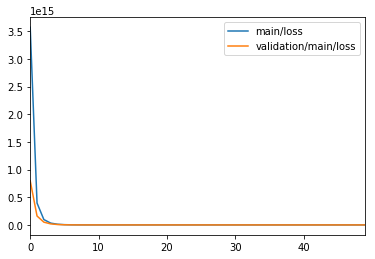

In [36]:
results[['main/loss', 'validation/main/loss']].plot()

In [37]:
loss = results['validation/main/loss'].values[-1]
loss

231483839.46666667

In [38]:
import math

In [39]:
math.sqrt(loss)

15214.592977357845